## `"Optuned"` `LightGBM ` Notebook Handler

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler

import joblib

### 1 Carga de Datos

Carga de datos. Los datos no contienen valores faltantes ni anómalos puesto que han sido tratados en `datathon_worked`. Las distribuciones de las características numéricas tienen una gran asimetría positiva con abundancia de datos atípicos, pero serán tratados mediante el scl `PowerTransformer()` de manera que estén más constreñidas y a una escala similar.

In [2]:
data_raw = pd.read_csv(
    "./cleaned_telcom_churn_construction.csv"
)
data_raw.head()

,Customer ID,network_age,tenure,spend_mo12,sms_spend,data_spend,data_consume,calls,onnet_spend,offnet_spend,complaint_calls,net_type_mo1,net_type_mo2,competitor_mo1,competitor_mo2,Churn Status
0,ADF0039,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,2G,2G,Uxaa,Mango,0
1,ADF0041,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,2G,2G,Uxaa,Mango,0
2,ADF0051,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,2G,2G,Weematel,Mango,0
3,ADF0060,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,2G,3G,Weematel,Mango,0
4,ADF0066,158,5.27,792.1144,28.63,108.75,107713.5820,101,7296,16636,1,2G,2G,Uxaa,Mango,0


In [9]:
X = data_raw.iloc[:,:-1]
y = data_raw[[data_raw.columns.tolist()[-1]]]

X

,Customer ID,network_age,tenure,spend_mo12,sms_spend,data_spend,data_consume,calls,onnet_spend,offnet_spend,complaint_calls,net_type_mo1,net_type_mo2,competitor_mo1,competitor_mo2
0,ADF0039,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,2G,2G,Uxaa,Mango
1,ADF0041,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,2G,2G,Uxaa,Mango
2,ADF0051,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,2G,2G,Weematel,Mango
3,ADF0060,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,2G,3G,Weematel,Mango
4,ADF0066,158,5.27,792.1144,28.63,108.75,107713.5820,101,7296,16636,1,2G,2G,Uxaa,Mango
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,ADF1290,3994,133.13,804.0848,7.00,0.00,2364.6768,127,30071,8091,2,Other,Other,PQza,Uxaa
1052,ADF1302,731,24.37,828.7404,3.52,2.50,35674.9864,660,10912,20756,7,Other,Other,PQza,Uxaa
1053,ADF1304,2971,99.03,832.7248,9.62,2.50,103008.5605,224,37401,29553,3,Other,Other,ToCall,Uxaa
1054,ADF1308,595,19.83,839.5724,73.80,8.75,229.4463,102,21304,7894,1,Other,Other,Uxaa,Uxaa


In [10]:
y

,Churn Status
0,0
1,0
2,0
3,0
4,0
...,...
1051,0
1052,0
1053,0
1054,0


*  `ColumnTransformer()` (Flexible Transformer for Hybrid Schemes) preparation:

    1. Dropping mute variable `Customer ID` 
    2. Dropping `network_age` and `spend_mo12` explained by other numerical features
    3. Power Transforming (Box-Cox type) numerical features except `complaint_calls` (pass-through)
    4. Dropping categorical variables

In [15]:
numerical_features = X.select_dtypes("number").columns.tolist()
numerical_features

['network_age',
 'tenure',
 'spend_mo12',
 'sms_spend',
 'data_spend',
 'data_consume',
 'calls',
 'onnet_spend',
 'offnet_spend',
 'complaint_calls']

In [21]:
numerical_features_totransform = [    
    'tenure',    
    'sms_spend',
    'data_spend',
    'data_consume',
    'calls',
    'onnet_spend',
    'offnet_spend'
]

numerical_features_todrop = [
    "network_age",
    "spend_mo12"
]

numerical_features_topass = ["complaint_calls"]

In [30]:
excluded = list(set(numerical_features_todrop).union(numerical_features_topass))

num_totransform = [f for f in numerical_features if f not in excluded]
num_totransform

['tenure',
 'sms_spend',
 'data_spend',
 'data_consume',
 'calls',
 'onnet_spend',
 'offnet_spend']

In [22]:
cat_features = X.select_dtypes("object").columns.tolist()
cat_features

['Customer ID',
 'net_type_mo1',
 'net_type_mo2',
 'competitor_mo1',
 'competitor_mo2']

In [26]:
ct = ColumnTransformer(
    [
        ("id_drop", "drop", cat_features[0]),
        ("num_drop", "drop", numerical_features_todrop),
        ("num_transform", PowerTransformer(), numerical_features_totransform),
        ("num_pass", "passthrough", numerical_features_topass),
        ("cat_drop", "drop", cat_features[1:])
    ]
)

ct.fit_transform(X)


array([[-1.53442273, -1.55768456, -0.88312607, ..., -0.1491    ,
         0.19640358,  2.        ],
       [ 0.17555233, -0.57087198, -0.88312607, ...,  0.2109361 ,
        -0.00319422,  1.        ],
       [ 0.83218859, -0.65298317, -0.88312607, ...,  0.98568573,
         0.91526878,  1.        ],
       ...,
       [ 1.10365892, -0.10431728, -0.61422276, ...,  1.64801755,
         1.10396019,  3.        ],
       [-0.54419724,  1.24674288, -0.02222374, ...,  1.34201693,
         0.30968162,  1.        ],
       [ 0.25275273,  0.44531476,  0.20503602, ...,  0.9644096 ,
         0.00524632,  1.        ]])

In [24]:
X

,Customer ID,network_age,tenure,spend_mo12,sms_spend,data_spend,data_consume,calls,onnet_spend,offnet_spend,complaint_calls,net_type_mo1,net_type_mo2,competitor_mo1,competitor_mo2
0,ADF0039,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,2G,2G,Uxaa,Mango
1,ADF0041,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,2G,2G,Uxaa,Mango
2,ADF0051,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,2G,2G,Weematel,Mango
3,ADF0060,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,2G,3G,Weematel,Mango
4,ADF0066,158,5.27,792.1144,28.63,108.75,107713.5820,101,7296,16636,1,2G,2G,Uxaa,Mango
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,ADF1290,3994,133.13,804.0848,7.00,0.00,2364.6768,127,30071,8091,2,Other,Other,PQza,Uxaa
1052,ADF1302,731,24.37,828.7404,3.52,2.50,35674.9864,660,10912,20756,7,Other,Other,PQza,Uxaa
1053,ADF1304,2971,99.03,832.7248,9.62,2.50,103008.5605,224,37401,29553,3,Other,Other,ToCall,Uxaa
1054,ADF1308,595,19.83,839.5724,73.80,8.75,229.4463,102,21304,7894,1,Other,Other,Uxaa,Uxaa


In [31]:
from optuned_lightgmb.lightgbm_telcom_churn import load_cleaned_telcom_churn, scaler

In [32]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
X          DataFrame         Customer ID  network<...>n[1056 rows x 15 columns]
data_raw   DataFrame         Customer ID  network<...>n[1056 rows x 16 columns]
y          DataFrame          Churn Status\n0    <...>\n[1056 rows x 1 columns]


In [38]:
X,y = load_cleaned_telcom_churn()
X.head()

,Customer ID,network_age,tenure,spend_mo12,sms_spend,data_spend,data_consume,calls,onnet_spend,offnet_spend,complaint_calls,net_type_mo1,net_type_mo2,competitor_mo1,competitor_mo2
0,ADF0039,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,2G,2G,Uxaa,Mango
1,ADF0041,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,2G,2G,Uxaa,Mango
2,ADF0051,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,2G,2G,Weematel,Mango
3,ADF0060,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,2G,3G,Weematel,Mango
4,ADF0066,158,5.27,792.1144,28.63,108.75,107713.5820,101,7296,16636,1,2G,2G,Uxaa,Mango


In [39]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Churn Status, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=.25,
    random_state=42
)

ct = scaler(X_train)
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [41]:
best_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "lambda_l1": 6.87009123162533e-07,
    "lambda_l2": 1.0728987685523281e-05,
    "num_leaves": 13,
    "feature_fraction": 0.45521319964959506,
    "bagging_fraction": 0.9180039750586256,
    "bagging_freq": 1,
    "min_child_samples": 9
}

In [44]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test)

In [99]:
max_rounds = 1000
early_stopping = 10

lgbfit = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=dtest,
    early_stopping_rounds=early_stopping
)

/home/hcf/anaconda3/envs/ml-nongpu/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.680825
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665933
[3]	valid_0's binary_logloss: 0.650819
[4]	valid_0's binary_logloss: 0.63615
[5]	valid_0's binary_logloss: 0.627477
[6]	valid_0's binary_logloss: 0.620461
[7]	valid_0's binary_logloss: 0.613577
[8]	valid_0's binary_logloss: 0.609303
[9]	valid_0's binary_logloss: 0.600428
[10]	valid_0's binary_logloss: 0.596061
[11]	valid_0's binary_logloss: 0.591598
[12]	valid_0's binary_logloss: 0.590794
[13]	valid_0's binary_logloss: 0.586895
[14]	valid_0's binary_logloss: 0.584287
[15]	valid_0's binary_logloss: 0.577712
[16]	valid_0's binary_logloss: 0.575709
[17]	valid_0's binary_logloss: 0.577991
[18]	valid_0's binary_logloss: 0.57523
[19]	valid_0's binary_logloss: 0.57433
[20]	valid_0's binary_logloss: 0.572184
[21]	valid_0's binary_logloss: 0.570758
[22]	valid_0's binary_logloss: 0.56794
[23]	valid_0's binary_logloss: 0.569272
[24]	valid_0's binary_logloss: 0

In [100]:
lgbfit.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('binary_logloss', 0.5679400889917702)])})

In [101]:
# From predict_proba to class
y_pred = np.round(lgbfit.predict(X_test)).astype(np.int8)

In [102]:
churn_test["predicted"] = y_pred

In [103]:
churn_test.rename(
    columns={
        "Churn Status": "observed"
    }, inplace=True
)

In [104]:
subset_pos = churn_test["observed"]==1
churn_test[subset_pos]["predicted"].value_counts()

1    78
0    54
Name: predicted, dtype: int64

In [105]:
subset_pos.sum()

132

In [106]:
subset_neg = churn_test["observed"]==0
churn_test[subset_neg]["predicted"].value_counts()

0    100
1     32
Name: predicted, dtype: int64

In [122]:
TP = churn_test[subset_pos]["predicted"].value_counts().iloc[0] # True Positive (Churn)
FN = churn_test[subset_pos]["predicted"].value_counts().iloc[1] # False Positive 

TN = churn_test[subset_neg]["predicted"].value_counts().iloc[0] # True Negatives
FP = churn_test[subset_neg]["predicted"].value_counts().iloc[1] # False Negatives

In [123]:
from sklearn.metrics import accuracy_score

accuracy_score(churn_test["observed"].values, y_pred)

0.6742424242424242

In [124]:
ACC = (TP+TN)/(TP+FP+TN+FN)
ACC

0.6742424242424242

In [112]:
# La Tasa de Fugados mal Clasificados es excesivamente alta en conjunto de test
FNR = FN/(FP+FN) 
FNR

0.37209302325581395

* <u>**Train**</u>

In [110]:
train_pred = np.round(lgbfit.predict(X_train)).astype(np.int8)
accuracy_score(y_train, train_pred)

0.8712121212121212

In [116]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [125]:
tp == TP, tn == TN, fp==FP, fn==FN

(True, True, True, True)

In [126]:
%whos DataFrame

Variable     Type         Data/Info
-----------------------------------
X            DataFrame         Customer ID  network<...>n[1056 rows x 15 columns]
churn_test   DataFrame          observed  predictio<...>n\n[264 rows x 3 columns]
data_raw     DataFrame         Customer ID  network<...>n[1056 rows x 16 columns]


### 2 Carga de Datos as is (`Kaggle Competition`)

Carga de datos de los disponibles de una `Kaggle Competition`. Los datos ya tienen el split en construcción (`train.csv`) y explotación (`test.csv`), por lo que el objetivo es rellenar `test.csv` con las predicciones que aporte el trabajo sobre `train.csv`

In [127]:
data_kaggle = pd.read_csv(
    "./kaggle_data/train.csv"
)
data_kaggle.head()

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Network type subscription in Month 1,Network type subscription in Month 2,Most Loved Competitor network in in Month 1,Most Loved Competitor network in in Month 2,Churn Status
0,ADF0039,123.0,4.10,76.7140,0.00,1.25,1.4951,14.0,564.0,6408.0,2.0,2G,2G,Uxaa,Mango,0.0
1,ADF0041,1316.0,43.87,98.8904,4.14,1.25,1.0244,27.0,1626.0,4373.0,1.0,2G,2G,Uxaa,Mango,0.0
2,ADF0051,2385.0,79.50,372.6300,3.51,1.25,6.0898,119.0,10411.0,22039.0,1.0,2G,2G,Weematel,Mango,0.0
3,ADF0059,1614.0,53.80,530.2000,6.85,1.25,3.3447,69.0,6822.0,6274.0,1.0,2G,2G,0,Mango,0.0
4,ADF0060,2175.0,72.50,554.1300,6.99,153.75,673204.0342,33.0,3387.0,7241.0,1.0,2G,3G,Weematel,Mango,0.0


In [128]:
data_kaggle.shape

(1401, 16)

In [130]:
data_kaggle.dropna(how="any").shape

(1202, 16)

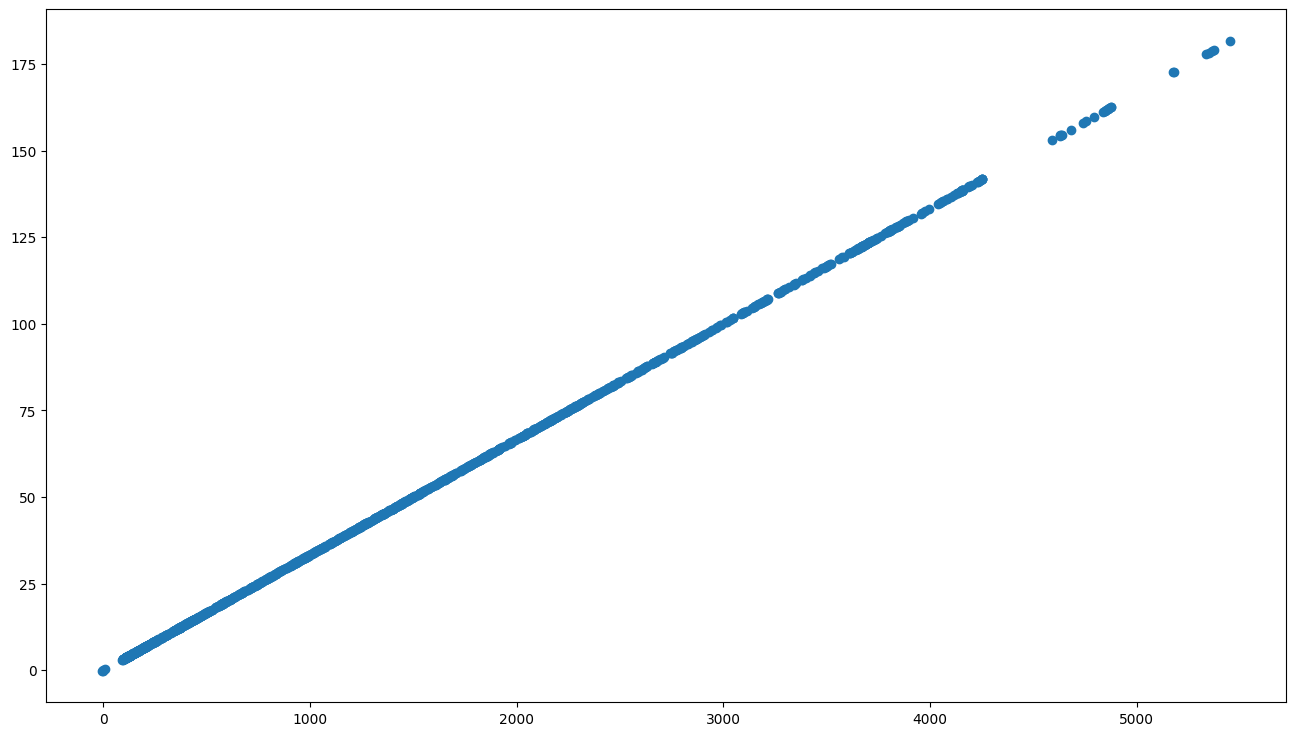

In [133]:
# Algunas comprobaciones graficas (correlacion perfecta network_age = customer_tenure)
f,ax = plt.subplots(figsize=(16,9))

ax.scatter(
    x=data_kaggle["network_age"],
    y=data_kaggle["Customer tenure in month"]
)

In [136]:
# Valores sin sentido
data_kaggle[data_kaggle["network_age"]<0]

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Network type subscription in Month 1,Network type subscription in Month 2,Most Loved Competitor network in in Month 1,Most Loved Competitor network in in Month 2,Churn Status
490,ADF0631,-5.0,-0.17,857.1008,63.47,190.03,1.565901e+06,204.0,716.0,1240.0,1.0,3G,3G,ToCall,ToCall,1.0
916,ADF1925,-4.0,-0.13,2898.8240,25.10,1.25,3.058533e+05,642.0,0.0,82221.0,1.0,3G,3G,Mango,Weematel,1.0
1163,ADF1623,-2.0,-0.07,130.5780,94.85,1.25,2.195300e+00,7.0,150.0,1121.0,1.0,Other,Other,Uxaa,Uxaa,1.0


In [137]:
data_kaggle["Most Loved Competitor network in in Month 1"].unique()

array(['Uxaa', 'Weematel', '0', 'Zintel', 'Mango', 'ToCall', 'PQza', nan],
      dtype=object)

* Cleaning Data

Limpiamos `NaN` y valores sin sentido. Dado que ya hemos analizado con el otro subconjunto de datos que las variables categóricas originales son irrelevantes a efectos predictivos, ni siquiera vamos a tratar de imputar o filtrar el valor `0` para el competidor preferido por el cliente en el primer mes.

1. Limpieza de NaNs y check

In [143]:
data_kaggle.dropna(inplace=True)

subset = data_kaggle["network_age"]>=0
data_kaggle = data_kaggle[subset]

data_kaggle[data_kaggle["network_age"]<0]

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Network type subscription in Month 1,Network type subscription in Month 2,Most Loved Competitor network in in Month 1,Most Loved Competitor network in in Month 2,Churn Status


In [139]:
data_kaggle.isna().sum()

Customer ID                                    0
network_age                                    0
Customer tenure in month                       0
Total Spend in Months 1 and 2 of 2017          0
Total SMS Spend                                0
Total Data Spend                               0
Total Data Consumption                         0
Total Unique Calls                             0
Total Onnet spend                              0
Total Offnet spend                             0
Total Call centre complaint calls              0
Network type subscription in Month 1           0
Network type subscription in Month 2           0
Most Loved Competitor network in in Month 1    0
Most Loved Competitor network in in Month 2    0
Churn Status                                   0
dtype: int64

In [140]:
data_kaggle.shape

(1199, 16)

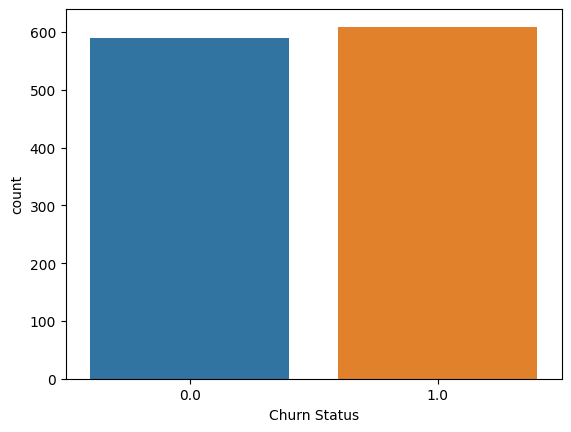

In [155]:
# Check Label Balancing
import seaborn as sns
sns.countplot(x="Churn Status", data=data_kaggle);

In [156]:
%pwd

'/home/hcf/Documentos/PDS01_datathon'

In [157]:
data_kaggle

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Network type subscription in Month 1,Network type subscription in Month 2,Most Loved Competitor network in in Month 1,Most Loved Competitor network in in Month 2,Churn Status
0,ADF0039,123.0,4.10,76.7140,0.00,1.25,1.495100e+00,14.0,564.0,6408.0,2.0,2G,2G,Uxaa,Mango,0.0
1,ADF0041,1316.0,43.87,98.8904,4.14,1.25,1.024400e+00,27.0,1626.0,4373.0,1.0,2G,2G,Uxaa,Mango,0.0
2,ADF0051,2385.0,79.50,372.6300,3.51,1.25,6.089800e+00,119.0,10411.0,22039.0,1.0,2G,2G,Weematel,Mango,0.0
3,ADF0059,1614.0,53.80,530.2000,6.85,1.25,3.344700e+00,69.0,6822.0,6274.0,1.0,2G,2G,0,Mango,0.0
4,ADF0060,2175.0,72.50,554.1300,6.99,153.75,6.732040e+05,33.0,3387.0,7241.0,1.0,2G,3G,Weematel,Mango,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,ADF1975,356.0,11.87,89.3780,16.73,8.75,1.332481e+03,4.0,0.0,2607.0,1.0,Other,Other,Zintel,Zintel,1.0
1221,ADF1978,107.0,3.57,128.5100,5.98,22.50,4.780016e+04,17.0,120.0,6476.0,2.0,Other,Other,Mango,Zintel,1.0
1222,ADF1979,107.0,3.57,139.1360,0.00,20.00,1.509482e+06,8.0,0.0,2806.0,1.0,Other,Other,Zintel,Zintel,1.0
1223,ADF1985,1361.0,45.37,204.3128,28.05,2.50,1.142600e+00,36.0,966.0,10314.0,1.0,Other,Other,Weematel,Zintel,1.0


In [159]:
print(data_kaggle.select_dtypes("number").columns.tolist())

['network_age', 'Customer tenure in month', 'Total Spend in Months 1 and 2 of 2017', 'Total SMS Spend', 'Total Data Spend', 'Total Data Consumption', 'Total Unique Calls', 'Total Onnet spend ', 'Total Offnet spend', 'Total Call centre complaint calls', 'Churn Status']


In [160]:
data_kaggle.rename(
    columns={
        'Total Spend in Months 1 and 2 of 2017': 'spend_mo12',
        'Total Call centre complaint calls': 'complaint_calls'
    },
    inplace=True
)

In [161]:
data_kaggle.to_csv(
    "./kaggle_data/cleaned_train.csv",
    index=False
)

In [162]:
data_kaggle

,Customer ID,network_age,Customer tenure in month,spend_mo12,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,complaint_calls,Network type subscription in Month 1,Network type subscription in Month 2,Most Loved Competitor network in in Month 1,Most Loved Competitor network in in Month 2,Churn Status
0,ADF0039,123.0,4.10,76.7140,0.00,1.25,1.495100e+00,14.0,564.0,6408.0,2.0,2G,2G,Uxaa,Mango,0.0
1,ADF0041,1316.0,43.87,98.8904,4.14,1.25,1.024400e+00,27.0,1626.0,4373.0,1.0,2G,2G,Uxaa,Mango,0.0
2,ADF0051,2385.0,79.50,372.6300,3.51,1.25,6.089800e+00,119.0,10411.0,22039.0,1.0,2G,2G,Weematel,Mango,0.0
3,ADF0059,1614.0,53.80,530.2000,6.85,1.25,3.344700e+00,69.0,6822.0,6274.0,1.0,2G,2G,0,Mango,0.0
4,ADF0060,2175.0,72.50,554.1300,6.99,153.75,6.732040e+05,33.0,3387.0,7241.0,1.0,2G,3G,Weematel,Mango,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,ADF1975,356.0,11.87,89.3780,16.73,8.75,1.332481e+03,4.0,0.0,2607.0,1.0,Other,Other,Zintel,Zintel,1.0
1221,ADF1978,107.0,3.57,128.5100,5.98,22.50,4.780016e+04,17.0,120.0,6476.0,2.0,Other,Other,Mango,Zintel,1.0
1222,ADF1979,107.0,3.57,139.1360,0.00,20.00,1.509482e+06,8.0,0.0,2806.0,1.0,Other,Other,Zintel,Zintel,1.0
1223,ADF1985,1361.0,45.37,204.3128,28.05,2.50,1.142600e+00,36.0,966.0,10314.0,1.0,Other,Other,Weematel,Zintel,1.0


In [165]:
data_kaggle["Churn Status"].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
1220    1
1221    1
1222    1
1223    1
1224    1
Name: Churn Status, Length: 1199, dtype: int64

### 3 Loading Optuna Runs

#### Run I: Naive Optuned

In [3]:
jl = joblib.load("optuna_runs/20230227_1202_lgb_optuna_study_batch.pkl")

In [7]:
jl.trials_dataframe().sort_values(by=["value"],ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,state
457,457,0.734848,2023-02-27 12:13:33.322045,2023-02-27 12:13:33.453231,0 days 00:00:00.131186,0.915722,7,0.769765,4.763620e-07,0.000141,43,118,COMPLETE
499,499,0.731061,2023-02-27 12:13:38.817337,2023-02-27 12:13:38.940260,0 days 00:00:00.122923,0.498122,4,0.666842,2.766598e-02,0.001684,52,149,COMPLETE
187,187,0.731061,2023-02-27 12:13:01.539356,2023-02-27 12:13:01.642477,0 days 00:00:00.103121,0.817952,7,0.642137,3.110861e-06,0.003207,44,150,COMPLETE
265,265,0.731061,2023-02-27 12:13:10.188796,2023-02-27 12:13:10.302571,0 days 00:00:00.113775,0.905276,7,0.642087,3.164546e-06,0.005366,49,103,COMPLETE
282,282,0.727273,2023-02-27 12:13:12.198977,2023-02-27 12:13:12.312232,0 days 00:00:00.113255,0.885487,7,0.620151,3.056210e-06,0.001782,47,103,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0.678030,2023-02-27 12:12:43.232131,2023-02-27 12:12:43.276191,0 days 00:00:00.044060,0.683181,2,0.792517,1.157461e-06,0.002972,93,2,COMPLETE
42,42,0.674242,2023-02-27 12:12:46.769330,2023-02-27 12:12:46.849331,0 days 00:00:00.080001,0.710146,2,0.602661,3.081747e-06,0.005003,79,94,COMPLETE
496,496,0.674242,2023-02-27 12:13:38.442133,2023-02-27 12:13:38.564312,0 days 00:00:00.122179,0.468369,7,0.402679,9.010266e-06,0.000014,37,107,COMPLETE
236,236,0.674242,2023-02-27 12:13:06.867828,2023-02-27 12:13:06.967489,0 days 00:00:00.099661,0.837164,4,0.630261,5.297695e-08,0.002366,50,3,COMPLETE


In [13]:
lgb_best_params = jl.best_params

##### `Refit` sobre todo el conjunto de Train (datamecum). El conjunto de Test no ha sido proporcionado, pero lo podemos simular via conjunto Kaggle 

In [18]:
import lightgbm as lgb
from lightgbm_telcom_churn import scaler as scl

In [14]:
train_datamecum = pd.read_csv(
    "./datamecum_data/cleaned_telcom_churn_construction.csv"
)

In [20]:
print(train_datamecum.columns.tolist())

['Customer ID', 'network_age', 'tenure', 'spend_mo12', 'sms_spend', 'data_spend', 'data_consume', 'calls', 'onnet_spend', 'offnet_spend', 'complaint_calls', 'net_type_mo1', 'net_type_mo2', 'competitor_mo1', 'competitor_mo2', 'Churn Status']


In [21]:
X = train_datamecum.drop(columns="Churn Status")
y = train_datamecum["Churn Status"]

In [22]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1051    0
1052    0
1053    0
1054    0
1055    0
Name: Churn Status, Length: 1056, dtype: int64

In [23]:
scaler = scl(X)
X = scaler.fit_transform(X)

In [28]:
dtrain = lgb.Dataset(X, label=y)

In [30]:
lgb_best_params

{'lambda_l1': 4.7636197832915546e-07,
 'lambda_l2': 0.00014095790951285922,
 'num_leaves': 118,
 'feature_fraction': 0.7697649236404007,
 'bagging_fraction': 0.9157223333068747,
 'bagging_freq': 7,
 'min_child_samples': 43}

In [ ]:
import sklearn.metrics

In [119]:
fixed_params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "feature_pre_filter" : False
}

lgb_best_params.update(fixed_params)
lgb_best_params

{'lambda_l1': 4.7636197832915546e-07,
 'lambda_l2': 0.00014095790951285922,
 'num_leaves': 118,
 'feature_fraction': 0.7697649236404007,
 'bagging_fraction': 0.9157223333068747,
 'bagging_freq': 7,
 'min_child_samples': 43,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False}

In [36]:
gbm = lgb.train(lgb_best_params, dtrain)

In [37]:
preds = gbm.predict(X)
pred_labels = np.rint(preds)
accuracy = sklearn.metrics.accuracy_score(y, pred_labels)

In [38]:
accuracy

0.9412878787878788

In [39]:
%whos DataFrame

Variable          Type         Data/Info
----------------------------------------
train_datamecum   DataFrame         Customer ID  network<...>n[1056 rows x 16 columns]


In [40]:
train_datamecum["Customer ID"]

0       ADF0039
1       ADF0041
2       ADF0051
3       ADF0060
4       ADF0066
         ...   
1051    ADF1290
1052    ADF1302
1053    ADF1304
1054    ADF1308
1055    ADF1313
Name: Customer ID, Length: 1056, dtype: object

In [41]:
train_kaggle = pd.read_csv(
    "./kaggle_data/cleaned_train.csv"
)

train_kaggle["Customer ID"]

0       ADF0039
1       ADF0041
2       ADF0051
3       ADF0059
4       ADF0060
         ...   
1194    ADF1975
1195    ADF1978
1196    ADF1979
1197    ADF1985
1198    ADF1995
Name: Customer ID, Length: 1199, dtype: object

In [56]:
clients_in_datamecum_train = [client for client in train_datamecum["Customer ID"].values.tolist()]
clients_in_kaggle_Train = [c for c in train_kaggle["Customer ID"].values.tolist()]

clients_test_datamecum = [c for c in clients_in_kaggle_Train if c not in clients_in_datamecum_train]

In [59]:
test_datamecum = train_kaggle[train_kaggle["Customer ID"].isin(clients_test_datamecum)]

In [61]:
test_datamecum.head()

,Customer ID,network_age,Customer tenure in month,spend_mo12,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,complaint_calls,Network type subscription in Month 1,Network type subscription in Month 2,Most Loved Competitor network in in Month 1,Most Loved Competitor network in in Month 2,Churn Status
3,ADF0059,1614.0,53.80,530.2000,6.85,1.25,3.344700e+00,69.0,6822.0,6274.0,1.0,2G,2G,0,Mango,0.0
148,ADF1211,3340.0,111.33,566.6600,0.00,0.00,2.871655e+05,210.0,502.0,920.0,1.0,2G,3G,0,Uxaa,0.0
159,ADF1269,3667.0,122.23,716.1000,24.12,1.25,2.969000e-01,89.0,34344.0,8592.0,4.0,2G,2G,0,Uxaa,0.0
209,ADF1514,3621.0,120.70,1235.2900,45.35,0.00,8.571758e+02,561.0,900.0,6193.0,2.0,2G,2G,0,Uxaa,0.0
278,ADF1825,431.0,14.37,2127.9144,79.49,62.50,1.308236e+06,779.0,7866.0,79394.0,2.0,2G,3G,0,Uxaa,1.0


In [62]:
X_test = test_datamecum.drop(columns=["Churn Status"])
y_test = test_datamecum["Churn Status"]

In [67]:
X_test.columns = train_datamecum.columns.tolist()[:-1]
X_test.columns

Index(['Customer ID', 'network_age', 'tenure', 'spend_mo12', 'sms_spend',
       'data_spend', 'data_consume', 'calls', 'onnet_spend', 'offnet_spend',
       'complaint_calls', 'net_type_mo1', 'net_type_mo2', 'competitor_mo1',
       'competitor_mo2'],
      dtype='object')

In [68]:
valid_x = scaler.transform(X_test)
valid_x

array([[ 0.3886742 , -0.30087826, -0.88312607, ...,  0.79135305,
         0.18509852,  1.        ],
       [ 1.25520247, -1.55768456, -1.39916193, ..., -0.18554265,
        -0.72041275,  1.        ],
       [ 1.37965105,  0.4737784 , -0.88312607, ...,  1.60010657,
         0.35660278,  4.        ],
       ...,
       [-1.59706212, -1.55768456,  0.39376193, ..., -1.48181948,
        -0.22264278,  1.        ],
       [ 0.2098268 ,  0.5740989 , -0.61422276, ...,  0.02722745,
         0.4595698 ,  1.        ],
       [-1.40169309,  0.43210374, -0.1890147 , ...,  1.04138685,
         1.67770574,  1.        ]])

In [69]:
gbm

In [71]:
test_preds = gbm.predict(valid_x)
test_pred_labels = np.rint(test_preds)
accuracy = sklearn.metrics.accuracy_score(y_test, test_pred_labels)

In [72]:
accuracy

0.6643356643356644

In [73]:
gbm.params

{'lambda_l1': 4.7636197832915546e-07,
 'lambda_l2': 0.00014095790951285922,
 'num_leaves': 118,
 'feature_fraction': 0.7697649236404007,
 'bagging_fraction': 0.9157223333068747,
 'bagging_freq': 7,
 'min_child_samples': 43,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'num_iterations': 100,
 'early_stopping_round': None}

#### Run II

In [88]:
jl = joblib.load("optuna_runs/20230227_1722_lgb_optuna_study_batch.pkl")
params = jl.best_params
params.update(fixed_params)
params

{'max_depth': 8,
 'num_leaves': 1741,
 'lambda_l1': 0.002034992742114325,
 'lambda_l2': 0.051899688418323375,
 'feature_fraction': 0.9657196674570263,
 'bagging_fraction': 0.7331080027978967,
 'bagging_freq': 3,
 'min_child_samples': 11,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt'}

In [89]:
dtrain = lgb.Dataset(X, label=y)
lgb.train(params, dtrain)

In [93]:
preds = gbm.predict(X)
pred_labels = np.rint(preds)
accuracy = sklearn.metrics.accuracy_score(y, pred_labels)
print(f"Accuracy on Train {accuracy}")

Accuracy on Train 0.9412878787878788


In [94]:
%whos DataFrame

Variable          Type         Data/Info
----------------------------------------
X_test            DataFrame         Customer ID  network<...>\n[143 rows x 15 columns]
test_datamecum    DataFrame         Customer ID  network<...>\n[143 rows x 16 columns]
train_datamecum   DataFrame         Customer ID  network<...>n[1056 rows x 16 columns]
train_kaggle      DataFrame         Customer ID  network<...>n[1199 rows x 16 columns]


In [98]:

test_preds = gbm.predict(valid_x)
test_pred_labels = np.rint(test_preds)
real_world_accuracy = sklearn.metrics.accuracy_score(y_test, test_pred_labels)
print(f"Accuracy on Test {real_world_accuracy}")

Accuracy on Test 0.6643356643356644


In [99]:
import os

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

In [117]:
list(get_files("./optuna_runs/"))

['20230227_1855_lgb_optuna_study_batch.pkl',
 '20230227_1722_lgb_optuna_study_batch.pkl',
 '20230227_1857_lgb_optuna_study_batch.pkl',
 '20230227_1754_lgb_optuna_study_batch.pkl']

#### Looping Optuna Runs Over the Same (`lgb`) Boosting Model

In [121]:
RUNS_PATH = "./optuna_runs"

train_accuracies = list()
test_accuracies = list()
best_params = list()

# Initializing lgb Dataset for Train is external to Params

for run in list(get_files(RUNS_PATH)):
    jl = joblib.load(RUNS_PATH + "/" + run)
    params = jl.best_params
    best_params.append(params)
    params.update(fixed_params)
    dtrain = lgb.Dataset(X,label=y)

    # Refit
    gbm = lgb.train(params, dtrain)
    # Metrics on Train
    preds = gbm.predict(X)
    pred_labels = np.rint(preds)
    train_accuracies.append(sklearn.metrics.accuracy_score(y, pred_labels))
    # Metrics on Test (Real-World)
    test_preds = gbm.predict(valid_x)
    test_pred_labels = np.rint(test_preds)
    test_accuracies.append(sklearn.metrics.accuracy_score(y_test, test_pred_labels))

In [122]:
train_accuracies

[0.7604166666666666, 1.0, 0.7481060606060606, 0.8522727272727273]

In [123]:
test_accuracies

[0.6363636363636364,
 0.7062937062937062,
 0.6433566433566433,
 0.6783216783216783]

In [124]:
pd.DataFrame(best_params)

,learning_rate,num_leaves,max_depth,min_data_in_leaf,max_bin,lambda_l1,lambda_l2,min_gain_to_split,bagging_fraction,feature_fraction,bagging_freq,objective,metric,verbosity,boosting_type,feature_pre_filter,min_child_samples
0,0.213237,1020,3,200.0,259.0,0.325543,1.651034e-07,1.767725,0.800000,0.700000,7,binary,binary_logloss,-1,gbdt,False,NaN
1,NaN,1741,8,NaN,NaN,0.002035,5.189969e-02,NaN,0.733108,0.965720,3,binary,binary_logloss,-1,gbdt,False,11.0
2,0.126541,500,4,200.0,237.0,0.000599,6.838286e+00,5.626694,0.800000,0.700000,5,binary,binary_logloss,-1,gbdt,False,NaN
3,NaN,29,8,NaN,NaN,0.024842,1.498194e+00,NaN,0.633922,0.977856,4,binary,binary_logloss,-1,gbdt,False,60.0
